In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from foursquareAPI import get_poi
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
%matplotlib inline

In [2]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df

,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [3]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [4]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    parking_sync = parking_sync.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                               "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})

    parkings[name] = parking_sync  # Save the synced data frame to dict

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
date                                                               
2022-03-04 09:31:53           0          80               0.0000   
2022-03-04 09:41:53           0          80               0.0000   
2022-03-04 09:51:53           0          80               0.0000   
2022-03-04 10:01:53           0          80               0.0000   
2022-03-04 10:11:53           0          80               0.0000   
...                         ...         ...                  ...   
2022-05-10 03:51:53          17          80               0.2125   
2022-05-10 04:01:53          16          80               0.2000   
2022-05-10 04:11:53          15          80               0.1875   
2022-05-10 04:21:53          16          80               0.2000   
2022-05-10 04:31:53          17          80               0.2125   

                     Restaurant_score  Art_score  Coffee_score  Bar_score  
date                        

In [5]:
parkings["Bezigrad"].dtypes

Zasedenost               int32
Kapaciteta               int32
Procent_zasedenosti    float64
Restaurant_score       float64
Art_score              float64
Coffee_score           float64
Bar_score              float64
dtype: object

In [6]:
curr_df = parkings["Bezigrad"][["Zasedenost"]]
curr_df

,Zasedenost
date,
2022-02-24 19:13:21,6
2022-02-24 19:23:21,5
2022-02-24 19:33:21,5
2022-02-24 19:43:21,6
2022-02-24 19:53:21,5
...,...
2022-05-10 04:33:21,10
2022-05-10 04:43:21,11
2022-05-10 04:53:21,13


In [24]:
data = curr_df.resample("D").mean()
print(data.dtypes)
data

Zasedenost    float64
dtype: object


,Zasedenost
date,
2022-02-24,4.379310
2022-02-25,6.097222
2022-02-26,3.097222
2022-02-27,2.569444
2022-02-28,10.159722
...,...
2022-05-06,23.256944
2022-05-07,22.416667
2022-05-08,3.986111


In [25]:
data.isna().sum()

Zasedenost    0
dtype: int64

<AxesSubplot:xlabel='date'>

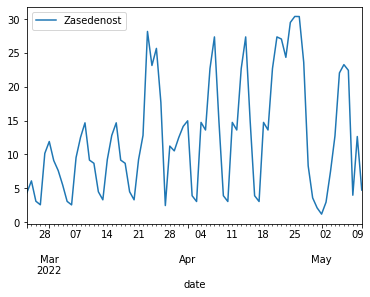

In [26]:
data.plot()

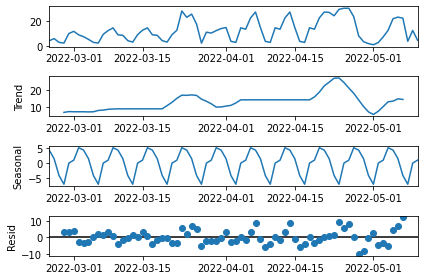

In [27]:
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date'>

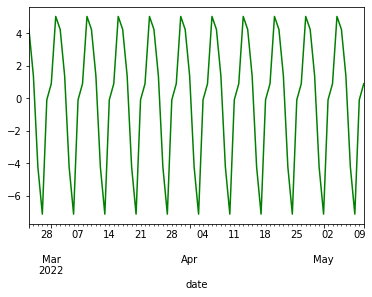

In [29]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [32]:
dftest = adfuller(data["Zasedenost"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
print("Podatki " + ("SO" if dftest[1] <= 0.05 else "NISO") + " stacionarni")

1. ADF :  -2.709974760583624
2. P-Value :  0.07232804770555445
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 67
5. Critical Values :
	 1% :  -3.5319549603840894
	 5% :  -2.905755128523123
	 10% :  -2.5903569458676765
Podatki NISO stacionarni


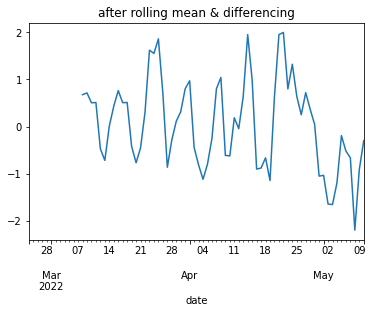

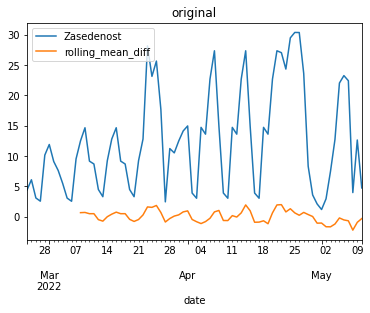

In [33]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [35]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag='AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t", key, ": ", val)
print("Podatki " + ("SO" if dftest[1] <= 0.05 else "NISO") + " stacionarni")


1. ADF :  -3.5534599924124435
2. P-Value :  0.006715704288506673
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315
Podatki SO stacionarni


In [37]:
model=ARIMA(data['Zasedenost'],order=(1,1,1))
history=model.fit()

In [39]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Zasedenost   No. Observations:                   76
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -244.315
Date:                Tue, 17 May 2022   AIC                            494.630
Time:                        16:55:19   BIC                            501.583
Sample:                    02-24-2022   HQIC                           497.406
                         - 05-10-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7050      0.118      5.997      0.000       0.475       0.935
ma.L1         -0.9888      0.093    -10.676      0.000      -1.170      -0.807
sigma2        38.5327      7.683      5.015      0.000      23.473      53.592
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.16   Prob(JB):                         0.63
Heteroskedasticity (H):               4.33   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

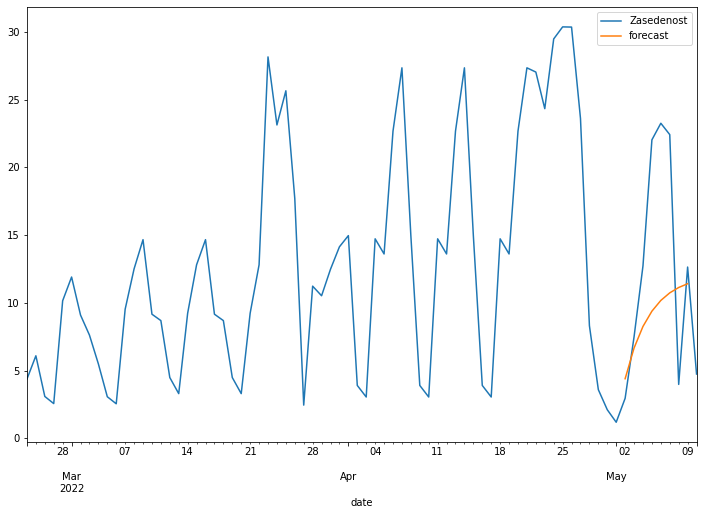

In [41]:
data['forecast']=history.predict(start='2022-05-02',end='2022-05-09',dynamic=True)
data[['Zasedenost','forecast']].plot(figsize=(12,8))

In [42]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()

<AxesSubplot:xlabel='date'>

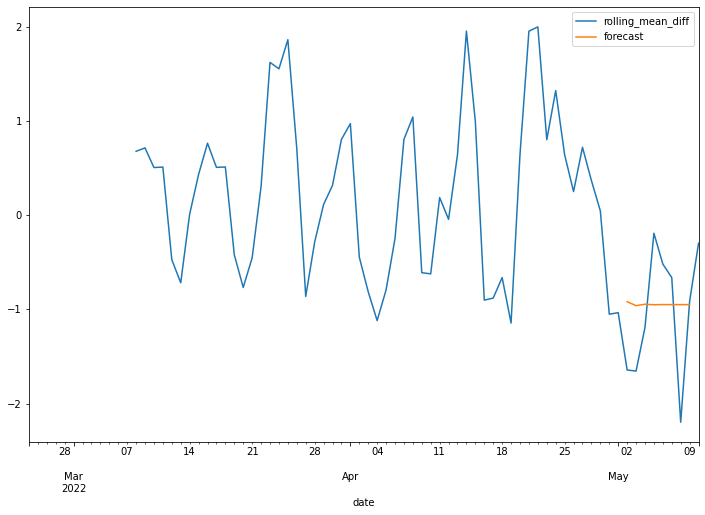

In [43]:
data['forecast']=model_fit.predict(start='2022-05-02',end='2022-05-09',dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

In [54]:
model=sm.tsa.statespace.SARIMAX(data['Zasedenost'],order=(6, 1, 4),seasonal_order=(1,1,1,52))
results=model.fit()

c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Max

In [64]:
results.save("models/SARIMAX_Test.pkl")

<AxesSubplot:xlabel='date'>

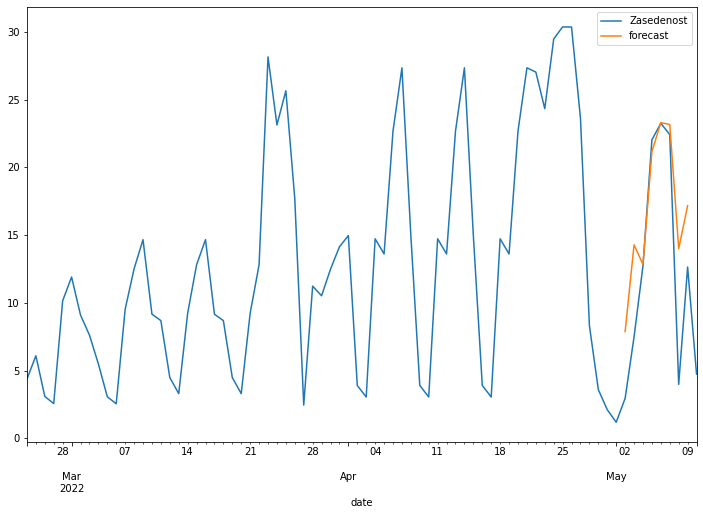

In [55]:
data['forecast'] = results.predict(start='2022-05-02', end='2022-05-09', dynamic=True)
data[['Zasedenost', 'forecast']].plot(figsize=(12, 8))


<AxesSubplot:>

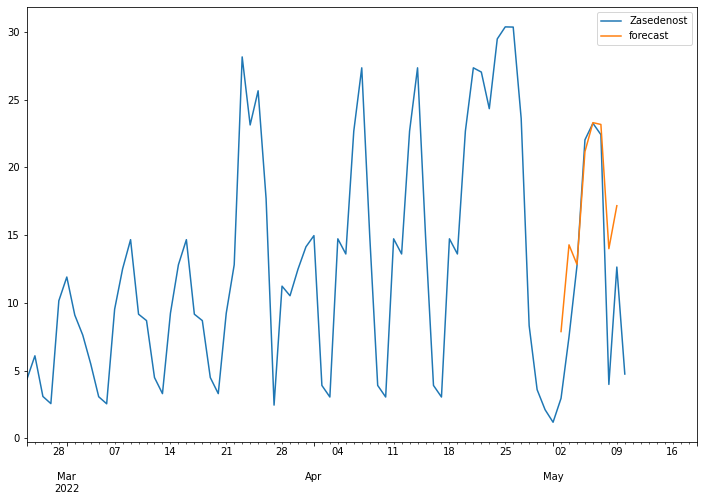

In [63]:
# Test loading the model
loaded_model = SARIMAXResults.load("SARIMAX_Test.pkl")

data['forecast'] = loaded_model.predict(start='2022-05-02', end='2022-05-09', dynamic=True)
data[['Zasedenost', 'forecast']].plot(figsize=(12, 8))

In [56]:
pred_date = [data.index[-1] + DateOffset(days=x) for x in range(0, 10)]


In [57]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,Zasedenost,rolling_mean_diff,forecast
2022-05-11,NaN,NaN,NaN
2022-05-12,NaN,NaN,NaN
2022-05-13,NaN,NaN,NaN
2022-05-14,NaN,NaN,NaN
2022-05-15,NaN,NaN,NaN
2022-05-16,NaN,NaN,NaN
2022-05-17,NaN,NaN,NaN
2022-05-18,NaN,NaN,NaN
2022-05-19,NaN,NaN,NaN


In [58]:
data=pd.concat([data,pred_date])
data

,Zasedenost,rolling_mean_diff,forecast
2022-02-24,4.37931,NaN,NaN
2022-02-25,6.097222,NaN,NaN
2022-02-26,3.097222,NaN,NaN
2022-02-27,2.569444,NaN,NaN
2022-02-28,10.159722,NaN,NaN
...,...,...,...
2022-05-15,NaN,NaN,NaN
2022-05-16,NaN,NaN,NaN
2022-05-17,NaN,NaN,NaN
2022-05-18,NaN,NaN,NaN


<AxesSubplot:>

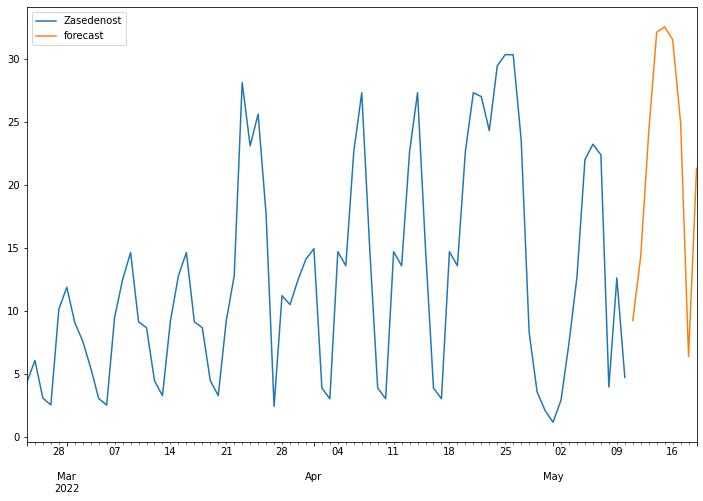

In [59]:
data['forecast'] = results.predict(start = "2022-05-11", end = "2022-05-19", dynamic= True)  
data[['Zasedenost', 'forecast']].plot(figsize=(12, 8))